## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRicoMulti.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.
mie_mono_tables = OrderedDict()
for wavelength in [.66, 1.240, 1.640, 2.13]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

#make extinction the density instead of lwc
solvers[.66].medium['cloud'].attrs["density_name"] = "extinction"
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"density" : 'lwc'})
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"extinction" : 'density'})
data = solvers[.66].medium['cloud'].drop_vars("density")
data = data.drop_vars("reff")
data = data.drop_vars("lwc")

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, data
)


In [6]:
# temp_grid = 15*(rte_grid.z.data-0.44)**(1.0/3)/90
# print(temp_grid)
# print(np.nanmean(temp_grid.ravel() * 90 / ((rte_grid.z.data.ravel()-0.44)**(1.0/3))))
# state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
# state_on_grid[:,:,:] = 15*(rte_grid.z.data-0.44)**(1.0/3)/90
# print(state_on_grid)
# z_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
# z_grid[:,:,:] = rte_grid.z.data
# print(np.unique(z_grid))
# print(initial_gridded_reff.ravel() / ((z_grid.ravel()-0.44)**(1.0/3)))
# np.array([np.nanmean(initial_gridded_reff.ravel() * scale_reff / ((z_grid.ravel()-0.44)**(1.0/3)))])

In [7]:
scale_reff = 90.0
class StateToGridVerticalPowerLaw(at3d.transforms.StateToGridMask):
    """
    Maps gridded data to and from a 1D vector based on 3D averaging
    conditioned on a 3D mask.
    This transform gives one unknown per domain.
    """
    def __call__(self, state):
        """
        Map from 1D state vector to gridded data using a volumetric mask.
        Parameters
        ----------
        state : np.ndarray, ndim=1
            The 1D state vector.
        Returns
        -------
        gridded_state : np.ndarray, ndim=3
            The gridded data of which a subset are unknowns that form the state vector.
        """
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
        print(np.unique(state_on_grid))
        state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
        state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
        return state_on_grid

    def inverse_transform(self, gridded_data):
        """
        Map from gridded data to 1D state vector using a volumetric mask.
        Parameters
        ----------
        gridded_state : np.ndarray, ndim=3
            The gridded data of which a subset are unknowns that form the state vector.
        Returns
        -------
        state : np.ndarray, ndim=1
            The 1D state vector.
        """
        z_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        z_grid[:,:,:] = rte_grid.z.data
        raw = gridded_data.ravel() * scale_reff / ((z_grid.ravel()-0.44)**(1.0/3))
        # print(np.unique(raw))
        finite = raw[np.isfinite(raw)]
        print(np.array([np.nanmean(finite)]))
        return np.array([np.nanmean(finite)])
        #return np.nanmean(gridded_data).ravel() * scale_reff
        

    def gradient_transform(self, gridded_gradient):
        """
        Projects gradients of gridded quantities onto the 1D state vector.
        Parameters
        ----------
        gridded_gradient : np.ndarray, ndim=3
            The gridded gradient values of which a subset correspond to entries
            in the state vector.
        Returns
        -------
        gradient_for_state : np.ndarray, ndim=1
            The gradient vector corresponding to the 1D state vector.
        """
        print("grad transform")
        gradient_for_state = self.inverse_transform(gridded_gradient)
        return gradient_for_state

    def inverse_bounds_transform(self, gridded_bounds):
        """
        Projects bounds of gridded quantities onto the 1D state vector.
        Parameters
        ----------
        gridded_bounds : np.ndarray, ndim=3
            The gridded gradient values of which a subset correspond to entries
            in the state vector. May be either upper or lower bounds.
        Returns
        -------
        state_bounds : np.ndarray, ndim=1
            The 1D vector of bounds corresponding to the 1D state vector.
        """
        # strictly this isn't true if the bounds are non-uniform
        # in space. But in the simplest case that that is true
        # then this will work.
        if np.size(np.unique(gridded_bounds)) == 1:
            state_bounds = self.inverse_transform(gridded_bounds)
        else:
            raise NotImplementedError(
                "Inverse Transform for non-uniform bounds for single variable"
                " have not yet been implemented."
            )
        return state_bounds


In [8]:

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
    density=(at3d.transforms.CoordinateTransformScaling(0, 1e-1), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
    reff=(at3d.transforms.CoordinateTransformScaling(0, 1), StateToGridVerticalPowerLaw(mask=carved_volume.mask.data))
    #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
    )
)

In [9]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

[0.]


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_7007/4204794284.py:41: RuntimeWarning: invalid value encountered in power
  raw = gridded_data.ravel() * scale_reff / ((z_grid.ravel()-0.44)**(1.0/3))
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_7007/4204794284.py:41: RuntimeWarning: invalid value encountered in true_divide
  raw = gridded_data.ravel() * scale_reff / ((z_grid.ravel()-0.44)**(1.0/3))


In [19]:
#regularization_reff = at3d.regularization.SpatialSmoothing(state_gen, "cloud", "reff", 10.0)

# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()
print(np.unique(max_bounds))

[12.65499589]
[3796.49876571]
[ 100.         3796.49876571]


In [11]:
# transform initial physical state to abstract state. 
initial_gridded_extinction = carved_volume.mask.data.astype(float)*10
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
initial_gridded_reff = carved_volume.mask.data.astype(float)*0+10
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))


[1265.49958857]


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_7007/4204794284.py:41: RuntimeWarning: invalid value encountered in power
  raw = gridded_data.ravel() * scale_reff / ((z_grid.ravel()-0.44)**(1.0/3))
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_7007/4204794284.py:41: RuntimeWarning: divide by zero encountered in true_divide
  raw = gridded_data.ravel() * scale_reff / ((z_grid.ravel()-0.44)**(1.0/3))


In [12]:

objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                  'verbose':True, 'maxiter':100, 'init_solution':True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)

<Figure size 640x480 with 0 Axes>

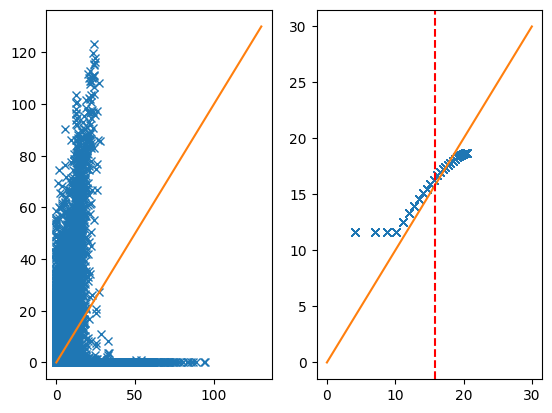

{'None': None}

In [29]:
%matplotlib inline
true_geo_extinct = 3.0*solvers[0.66].medium['cloud'].lwc.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)

def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            true_geo_extinct.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[2.13].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)
plot(None)

In [14]:

# optimizer = at3d.optimize.Optimizer(objective_function,prior_fn=regularization_reff, callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
optimizer = at3d.optimize.Optimizer(objective_function, callback_fn=callback, options={'maxiter': 100, 'maxls': 8, 'disp': True, 'gtol': 1e-16})#, 'ftol': 1e-16})


[ 0.          4.80883079  6.05874714  6.93553415  7.63354306  8.22298499
  8.73822546  9.19896238  9.61766159 10.00277114 10.36031188 10.69474394
 11.0094742  11.30717065 11.58996634 11.85959657 12.11749428 12.36485809
 12.60270192 12.83189202 13.05317502 13.26719954 13.47453302 13.6756751
 13.87106829 14.06110654         nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.629  0.956E-01    31968   228.05  0.891   [Radiance 1.640 micron]
     1  -0.636  0.876E-01    31968   228.05  0.891   [Radiance 1.240 micron]
     1  -0.631  0.663E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     1  -0.606  0.107E+00    31968   228.05  0.891   [Radiance 2.130 micron]
     2  -0.964  0.970E-01    31968   228.05  0.891   [Radiance 1.64

<Figure size 640x480 with 0 Axes>

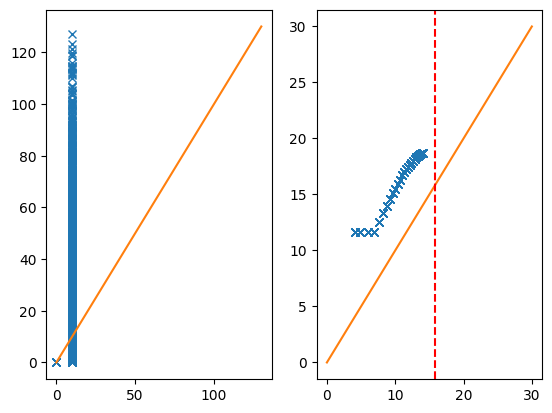

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28351     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97227D+05    |proj g|=  7.19286D+00
[ 0.          4.83616327  6.0931839   6.9749544   7.67693066  8.26972286
  8.78789187  9.25124752  9.67232654 10.05962498 10.41919791 10.75553083
 11.07204995 11.37143845 11.65584149 11.92700425 12.18636781 12.43513758
 12.67433327 12.90482604 13.12736677 13.34260776 13.55111969 13.75340503
 13.94990879 14.14102718         nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.629  0.696E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     1  -0.627  0.100E+00    31968   228.05  0.891   [Radiance 1.640

<Figure size 640x480 with 0 Axes>

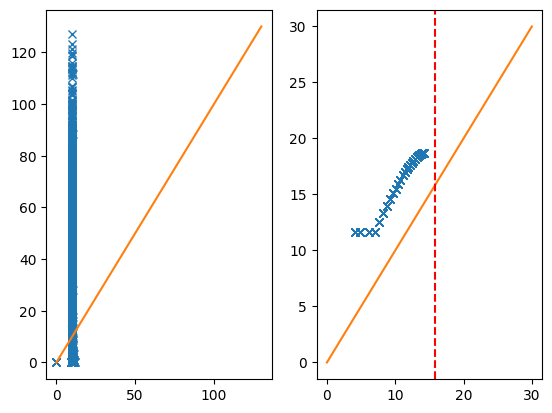


At iterate    1    f=  1.91607D+05    |proj g|=  7.12888D+00


<Figure size 640x480 with 0 Axes>

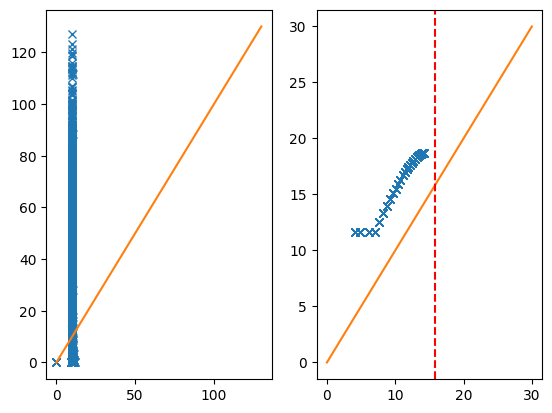

[ 0.          7.15530557  9.0151201  10.31973638 11.35833959 12.23540041
 13.0020531  13.68760714 14.31061114 14.88363536 15.41563853 15.91325713
 16.38156039 16.82451818 17.24530436 17.64650099 18.03024021 18.39830548
 18.75220549 19.09322918 19.42248749 19.74094552 20.04944763 20.34873724
 20.63947276 20.9222404          nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.523  0.454E+00    31968   147.52  0.576   [Radiance 0.660 micron]
     1  -0.522  0.455E+00    31968   147.52  0.576   [Radiance 1.240 micron]
     1  -0.502  0.351E+00    31968   147.52  0.576   [Radiance 2.130 micron]
     1  -0.515  0.418E+00    31968   147.52  0.576   [Radiance 1.640 micron]
     2  -1.006  0.583E+00    31968   147.52  0.576   [Radiance 0.6

<Figure size 640x480 with 0 Axes>

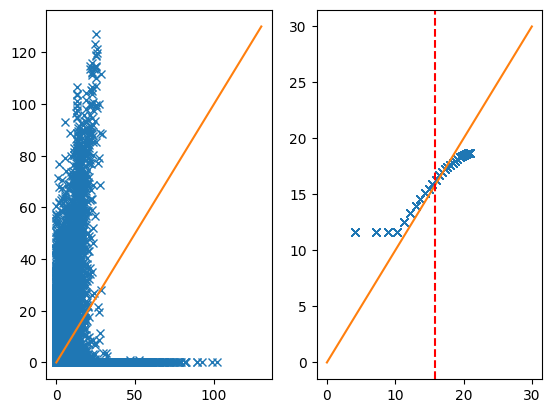


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


[ 0.          4.86325262  6.12731435  7.014024    7.71993233  8.316045
  8.83711648  9.30306759  9.72650524 10.1159731  10.47756015 10.815777
 11.13406908 11.43513458 11.72113068 11.99381233 12.2546287  12.50479193
 12.74532745 12.97711131 13.20089859 13.41734523 13.62702512 13.83044354
 14.028048   14.22023693         nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.627  0.735E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     1  -0.603  0.112E+00    31968   228.05  0.891   [Radiance 2.130 micron]
     1  -0.632  0.950E-01    31968   228.05  0.891   [Radiance 1.240 micron]
     1  -0.625  0.104E+00    31968   228.05  0.891   [Radiance 1.640 micron]
     2  -0.968  0.705E-01    31968   228.05  0.891   [Radiance 0.660 m

<Figure size 640x480 with 0 Axes>

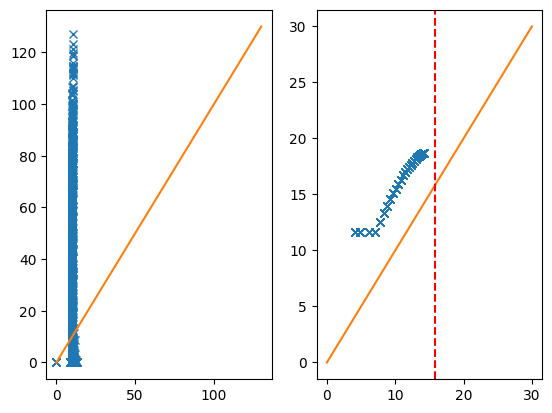

[ 0.          4.97161003  6.26383612  7.17030242  7.89193898  8.50133356
  9.03401496  9.51034785  9.94322005 10.34136559 10.7110091  11.05676172
 11.38214561 11.68991911 11.98228744 12.26104467 12.52767225 12.78340934
 13.02930419 13.26625239 13.49502584 13.7162951  13.93064683 14.13859759
 14.34060485 14.5370759          nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.620  0.956E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     1  -0.597  0.137E+00    31968   228.05  0.891   [Radiance 2.130 micron]
     1  -0.618  0.129E+00    31968   228.05  0.891   [Radiance 1.640 micron]
     1  -0.625  0.117E+00    31968   228.05  0.891   [Radiance 1.240 micron]
     2  -0.960  0.933E-01    31968   228.05  0.891   [Radiance 0.6

<Figure size 640x480 with 0 Axes>

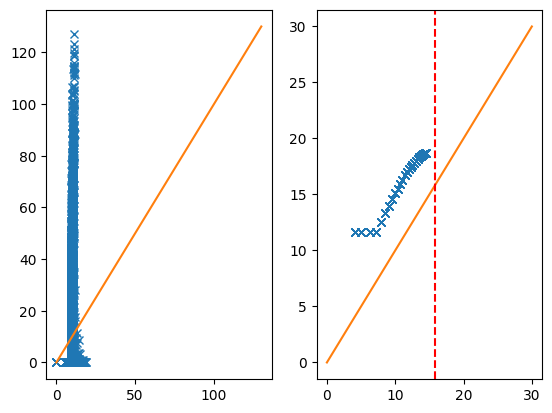

[ 0.          5.18781444  6.53623662  7.48212315  8.23514211  8.87103791
  9.42688446  9.92393202 10.37562889 10.7910889  11.1768074  11.53759604
 11.87713016 12.19828806 12.50337085 12.79425062 13.07247324 13.33933178
 13.59592006 13.84317262 14.08189492 14.31278669 14.53646011 14.75345419
 14.9642463  15.16926146         nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.606  0.214E+00    31968   228.04  0.891   [Radiance 0.660 micron]
     1  -0.611  0.191E+00    31968   228.04  0.891   [Radiance 1.240 micron]
     1  -0.586  0.180E+00    31968   228.04  0.891   [Radiance 2.130 micron]
     1  -0.606  0.171E+00    31968   228.04  0.891   [Radiance 1.640 micron]
     2  -0.948  0.318E+00    31968   228.04  0.891   [Radiance 0.6

<Figure size 640x480 with 0 Axes>

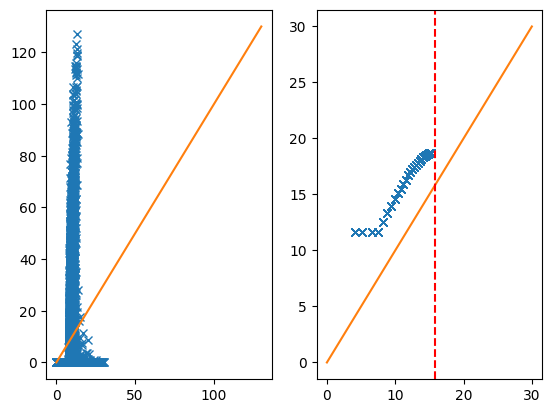


At iterate    2    f=  1.31844D+05    |proj g|=  6.33350D+00


<Figure size 640x480 with 0 Axes>

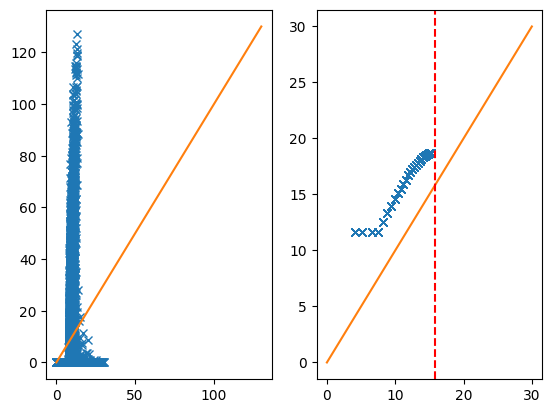

[ 0.          7.02161701  8.84668308 10.12692412 11.14612223 12.0067962
 12.75912487 13.43187014 14.04323403 14.60555196 15.12761527 15.61593644
 16.07549    16.51017165 16.92309593 17.31679666 17.69336616 18.05455456
 18.40184236 18.73649441 19.05960092 19.37210893 19.67484704 19.96854477
 20.25384824 20.5313327          nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.497  0.359E+00    31968   140.47  0.549   [Radiance 0.660 micron]
     1  -0.495  0.362E+00    31968   140.47  0.549   [Radiance 1.240 micron]
     1  -0.499  0.330E+00    31968   140.47  0.549   [Radiance 1.640 micron]
     1  -0.499  0.275E+00    31968   140.47  0.549   [Radiance 2.130 micron]
     2  -0.998  0.472E+00    31968   140.47  0.549   [Radiance 0.66

<Figure size 640x480 with 0 Axes>

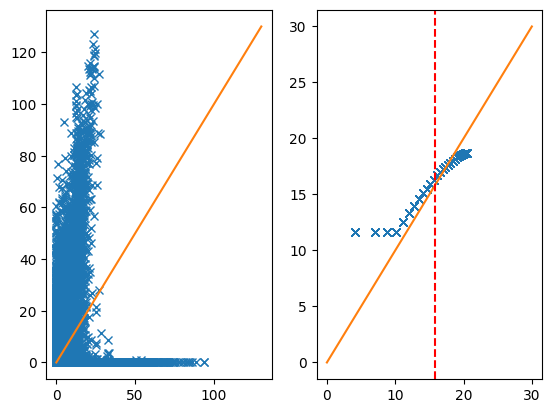


At iterate    3    f=  4.49092D+04    |proj g|=  9.76604D-01


<Figure size 640x480 with 0 Axes>

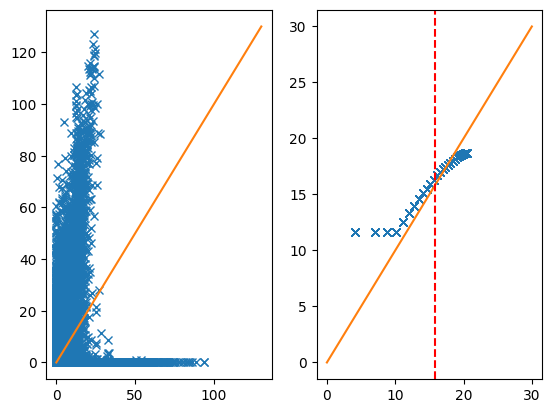

[ 0.          7.70089618  9.7025212  11.10661421 12.2244107  13.16834724
 13.99345703 14.73128444 15.40179236 16.01850957 16.59107788 17.12663979
 17.63065108 18.10738432 18.56025536 18.99204315 19.4050424  19.80117258
 20.18205739 20.54908407 20.90344826 21.24618865 21.57821398 21.90032437
 22.21322842 22.51755703         nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.554  0.377E+00    31968   150.53  0.588   [Radiance 0.660 micron]
     1  -0.531  0.374E+00    31968   150.53  0.588   [Radiance 1.640 micron]
     1  -0.515  0.341E+00    31968   150.53  0.588   [Radiance 2.130 micron]
     1  -0.547  0.383E+00    31968   150.53  0.588   [Radiance 1.240 micron]
     2  -1.034  0.450E+00    31968   150.53  0.588   [Radiance 0.6

<Figure size 640x480 with 0 Axes>

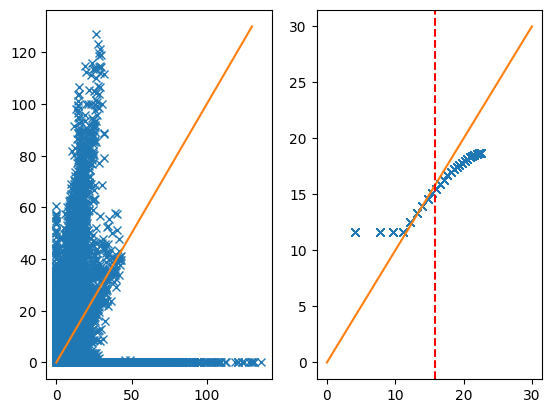

[ 0.          7.02161701  8.84668308 10.12692412 11.14612223 12.0067962
 12.75912487 13.43187014 14.04323403 14.60555196 15.12761527 15.61593644
 16.07549    16.51017165 16.92309593 17.31679666 17.69336616 18.05455456
 18.40184236 18.73649441 19.05960092 19.37210893 19.67484704 19.96854477
 20.25384824 20.5313327          nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.499  0.330E+00    31968   140.47  0.549   [Radiance 1.640 micron]
     1  -0.497  0.359E+00    31968   140.47  0.549   [Radiance 0.660 micron]
     1  -0.499  0.275E+00    31968   140.47  0.549   [Radiance 2.130 micron]
     1  -0.495  0.362E+00    31968   140.47  0.549   [Radiance 1.240 micron]
     2  -0.956  0.476E+00    31968   140.47  0.549   [Radiance 1.64

<Figure size 640x480 with 0 Axes>

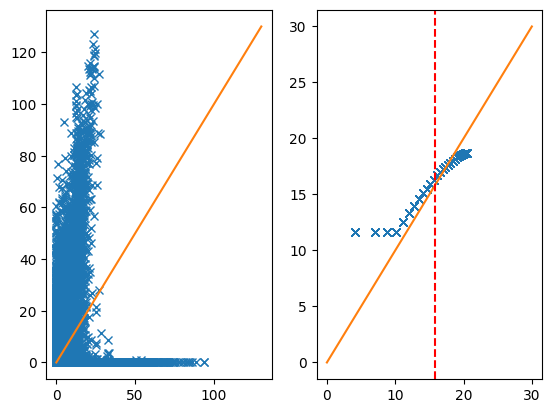


At iterate    4    f=  4.49092D+04    |proj g|=  9.76604D-01


<Figure size 640x480 with 0 Axes>

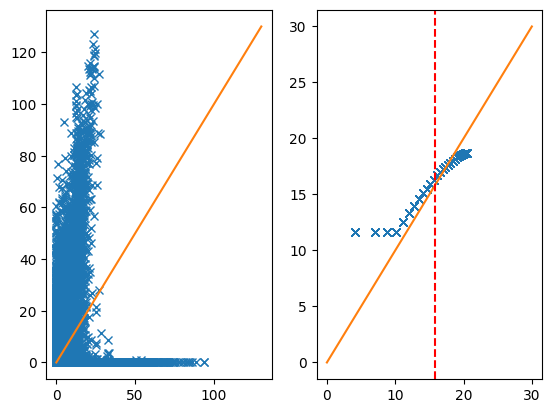


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      4     16  17299     0  8341   9.766D-01   4.491D+04
  F =   44909.234305615399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [15]:
import warnings
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 400
result = optimizer.minimize(x0)

[1847.81994273]
[ 0.          7.02161701  8.84668308 10.12692412 11.14612223 12.0067962
 12.75912487 13.43187014 14.04323403 14.60555196 15.12761527 15.61593644
 16.07549    16.51017165 16.92309593 17.31679666 17.69336616 18.05455456
 18.40184236 18.73649441 19.05960092 19.37210893 19.67484704 19.96854477
 20.25384824 20.5313327          nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.497  0.359E+00    31968   140.47  0.549   [Radiance 0.660 micron]
     1  -0.499  0.330E+00    31968   140.47  0.549   [Radiance 1.640 micron]
     1  -0.499  0.275E+00    31968   140.47  0.549   [Radiance 2.130 micron]
     1  -0.495  0.362E+00    31968   140.47  0.549   [Radiance 1.240 micron]
     2  -0.998  0.472E+00    31968   140.47  0.549 

<Figure size 640x480 with 0 Axes>

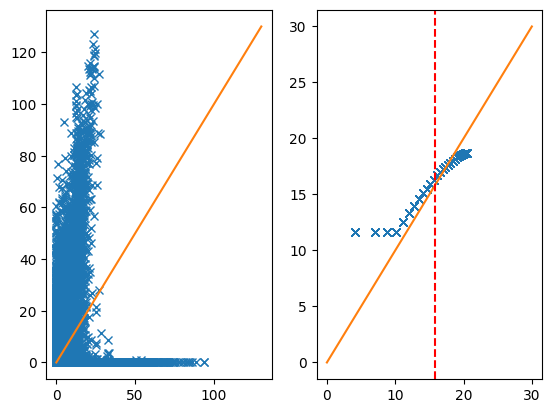

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28351     M =           10

At X0     11334 variables are exactly at the bounds

At iterate    0    f=  4.49092D+04    |proj g|=  9.76604D-01
[ 0.          7.02532805  8.8513587  10.13227637 11.15201314 12.01314199
 12.76586828 13.43896911 14.05065611 14.61327124 15.13561047 15.62418972
 16.08398617 16.51889755 16.93204006 17.32594887 17.7027174  18.0640967
 18.41156804 18.74639696 19.06967423 19.38234742 19.68524552 19.97909848
 20.26455274 20.54218385         nan]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.484  0.344E+00    31968   187.00  0.730   [Radiance 0.660 micron]
     1  -0.475  0.316E+00    31968   187.00  0.730   [Radiance 1.640 

KeyboardInterrupt: 

     9  -2.436  0.471E-01    38980   196.56  0.768   [Radiance 0.660 micron]
     9  -2.459  0.517E-01    39652   197.39  0.771   [Radiance 1.240 micron]
     9  -2.461  0.504E-01    40342   198.39  0.775   [Radiance 1.640 micron]
     9  -2.422  0.540E-01    40508   198.65  0.776   [Radiance 2.130 micron]
    10  -2.531  0.407E-01    40272   197.99  0.773   [Radiance 0.660 micron]
    10  -2.527  0.418E-01    41711   199.76  0.780   [Radiance 1.240 micron]
    10  -2.521  0.412E-01    42382   200.73  0.784   [Radiance 1.640 micron]
    10  -2.489  0.443E-01    42490   200.84  0.785   [Radiance 2.130 micron]
    11  -2.663  0.347E-01    42043   200.06  0.781   [Radiance 0.660 micron]
    11  -2.624  0.353E-01    43888   202.20  0.790   [Radiance 1.240 micron]
    11  -2.604  0.352E-01    44676   203.14  0.794   [Radiance 1.640 micron]
    11  -2.583  0.376E-01    44764   203.28  0.794   [Radiance 2.130 micron]
    12  -2.665  0.300E-01    44082   202.41  0.791   [Radiance 0.660 micron]

In [16]:
for i in range(10):
    if result.message == "CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH":
        result = optimizer.minimize(state_gen.get_state())